# **CycleGAN**

#####  
Original paper available at https://arxiv.org/abs/1703.10593

Last modified by William Huang (ucfnhua@ucl.ac.uk) on 14 December 2021. Copyright reserved by the TensorFlow authors (2019).

## Set Up Pipeline

Import the generator and the discriminator from [tensorflow_examples](https://github.com/tensorflow/examples) or a git.

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git
#!pip install git+https://github.com/WilliamShengYangHuang/Making-Design-with-Pix2Pix.git 

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-z9bwvsst
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-z9bwvsst


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import glob

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

from google.colab import drive

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

## List devices

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3386412009702169461
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13308245409410553876
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

## Input pipeline and data augmentation

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def _parse_function(filename, filename_):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string, channels=3)
  image = tf.cast(image_decoded, tf.float32)
  image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = tf.image.random_crop(image,[256, 256, 3])
  image = tf.image.random_flip_left_right(image)
  new_img = (image - 127.5) / 127.5

  image_string_ = tf.io.read_file(filename_)
  image_decoded_ = tf.image.decode_jpeg(image_string_, channels=3)
  image_ = tf.cast(image_decoded_, tf.float32)
  image_ = tf.image.resize(image_, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image_ = tf.image.random_crop(image_,[256, 256, 3])
  image_ = tf.image.random_flip_left_right(image_)
  new_img_ = (image_ - 127.5) / 127.5
  return new_img, new_img_

In [ ]:
def get_data(dataI, dataC):
  apple_list = glob.glob(dataI)
  apple_list = tf.convert_to_tensor(apple_list)
  orange_list = glob.glob(dataC)
  orange_list = tf.convert_to_tensor(orange_list)

  image_que = tf.data.Dataset.from_tensor_slices((apple_list, orange_list))


  image_que = image_que.map(_parse_function)

  batch_size = 1
  dataset = image_que.batch(batch_size)

  """
  # step 4: create iterator and final input tensor
  iterator = dataset.__iter__()
  image_batch, cartoon_batch = iterator.get_next()
  """
  return dataset

In [ ]:
# Place the dataset in your Google Drive 
drive.mount("/content/drive")

######## set dataset path ########-------------------------------------------------------------------------
folder_name = 'cycle_20220105' #@param{type:"string"}
path = "/content/drive/My Drive/" + folder_name 
print('path = ' + path)

os.chdir(path) # change the current working directory to the given path
os.listdir(path) # list all the entries in the directory given by path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
path = /content/drive/My Drive/cycle_20220105


['trainA', 'testB', 'testA', 'trainB']

In [ ]:
data_format = '.jpg' #@param{type:"string"}
image_data = get_data(path + "/trainA/*" + data_format, 
                      path + "/trainB/*" + data_format)

In [ ]:
sample = next(iter(image_data))
# print(sample)
sample_A = sample[0] # trainA data
# print(sample_A)
sample_b = sample[1] # trainB data

In [ ]:
ls # list files

testA/  testB/  trainA/  trainB/


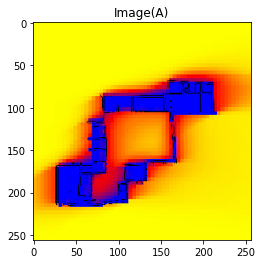

In [ ]:
plt.subplot(111)
plt.title('Image(A)')
plt.imshow(sample_A.numpy().squeeze() * 0.5 + 0.5)

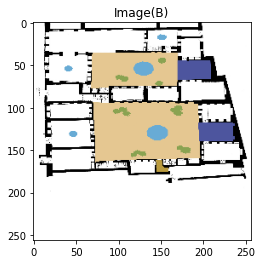

In [ ]:
plt.subplot(111)
plt.title('Image(B)')
plt.imshow(sample_b.numpy().squeeze() * 0.5 + 0.5)

## Import and utilise Pix2Pix model

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

## Defining loss functions

在 CycleGAN 中，没有可训练的成对数据，因此无法保证输入 `x` 和 目标 `y` 数据对在训练期间是有意义的。所以为了强制网络学习正确的映射，作者提出了循环一致损失。

判别器损失和生成器损失和 [pix2pix](https://google.tensorflow.cn/tutorials/generative/pix2pix#define_the_loss_functions_and_the_optimizer) 中所使用的类似。

In [ ]:
LAMBDA = 50

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

循环一致意味着结果应接近原始输出。例如，将一句英文译为法文，随后再从法文翻译回英文，最终的结果句应与原始句输入相同。

在循环一致损失中，

* 图片 $X$ 通过生成器 $G$ 传递，该生成器生成图片 $\hat{Y}$。
* 生成的图片 $\hat{Y}$ 通过生成器 $F$ 传递，循环生成图片 $\hat{X}$。
* 在 $X$ 和 $\hat{X}$ 之间计算平均绝对误差。

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$


![循环损失](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cycle_loss.png?raw=1)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss1

如上所示，生成器 $G$ 负责将图片 $X$ 转换为 $Y$。一致性损失表明，如果您将图片 $Y$ 馈送给生成器 $G$，它应当生成真实图片 $Y$ 或接近于 $Y$ 的图片。

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

为所有生成器和判别器初始化优化器。

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [ ]:
checkpoint_path = '/content/drive/My Drive/cycle_sky/checkpoints' #@param{type:"string"}

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


## Training

In [ ]:
# set epochs number
EPOCHS = 512 #@param {type:"slider", min:1, max:512, step:1} 

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title_domain_A = 'Input image' #@param {type:"string"}
  title_domain_B = 'Prediction' #@param {type:"string"}
  title = [title_domain_A, title_domain_B]

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  save_in = '.png' #@param [".jpg", ".png", ".bmp"] {allow-input: true}
  plt.savefig(path + 'generated_image' + save_in) 
  plt.show()
  

尽管训练循环看起来很复杂，其实包含四个基本步骤：

* 获取预测。
* 计算损失值。
* 使用反向传播计算损失值。
* 将梯度应用于优化器。

In [ ]:
LOSS = []

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent 设置为 Ture，因为 GradientTape 被多次应用于计算梯度。
  with tf.GradientTape(persistent=True) as tape:
    # generator G (X -> Y)
    # generator F (Y -> X)
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x 和 same_y 用于一致性损失。
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # 计算损失。
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
      
    # 总生成器损失 = 对抗性损失 + 循环损失。
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # 计算生成器和判别器损失。
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  print(generator_g_gradients)
  print(generator_f_gradients)
  print(discriminator_x_gradients)
  print(discriminator_y_gradients)
  
  # 将梯度应用于优化器。
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

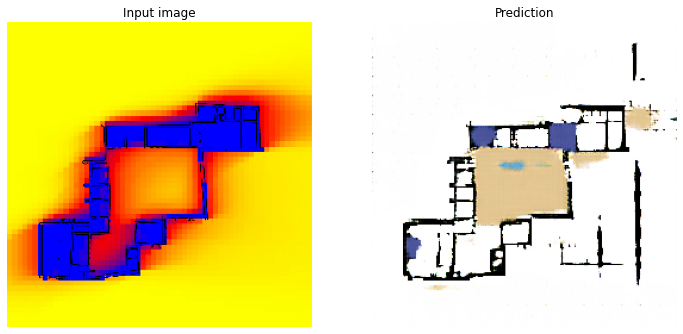

Time taken for epoch 512 is 7.191691160202026 sec



In [ ]:
for epoch in range(EPOCHS):
  start = time.time() # save the real world starting time of each epoch 

  n = 0
  for image_x, image_y in image_data:
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # 使用一致的图像（sample_horse），以便模型的进度清晰可见。
  generate_images(generator_g, sample_A)

  checkpoint_saved_every = 50 #@param{type:"slider", Min: 0, Max: 50, step: 1}
  if (epoch + 1) % checkpoint_saved_every == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

## Create with the given design conditions

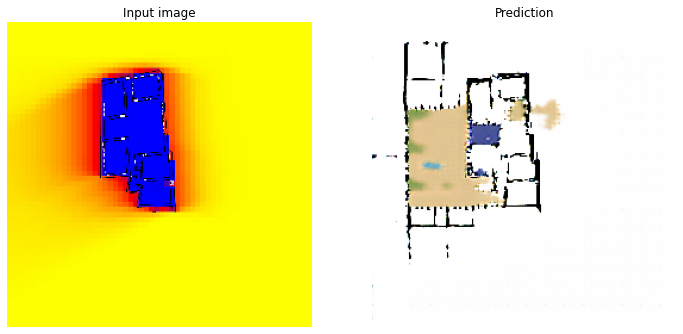

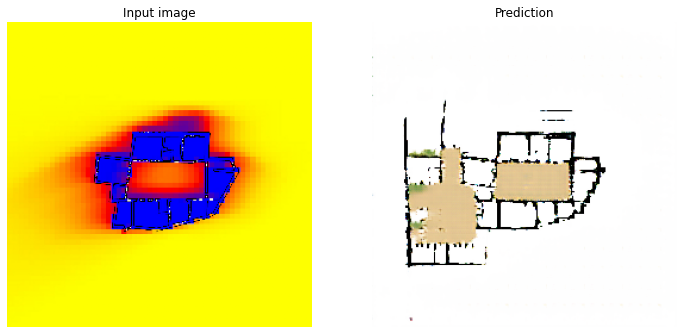

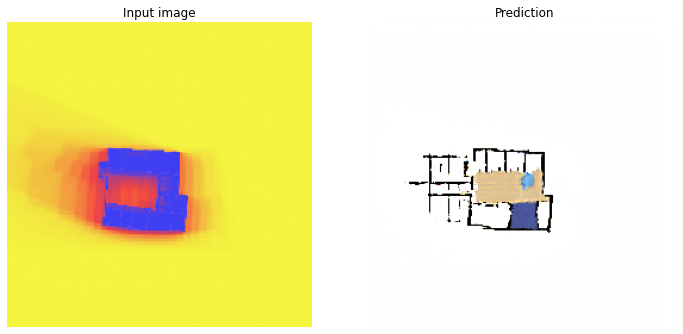

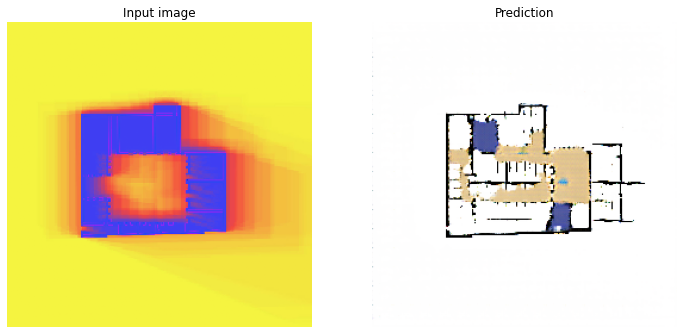

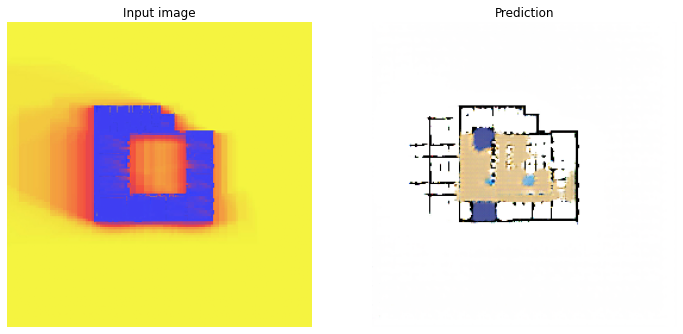

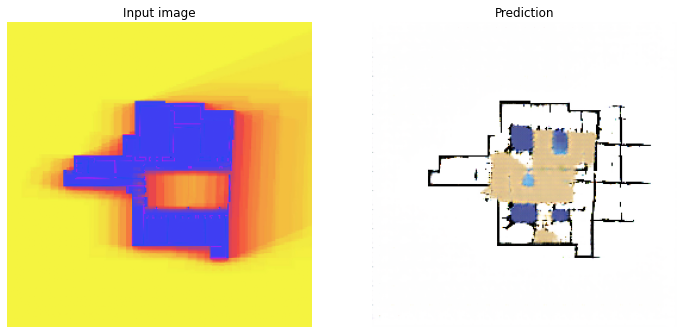

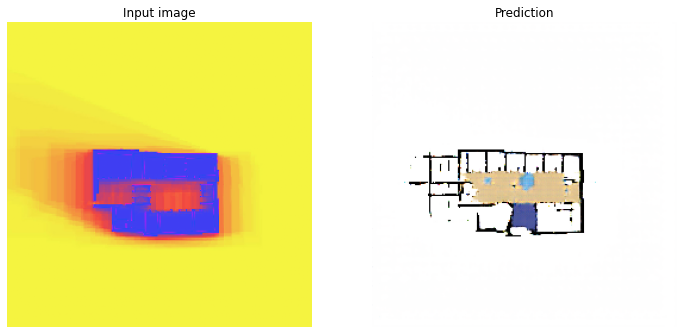

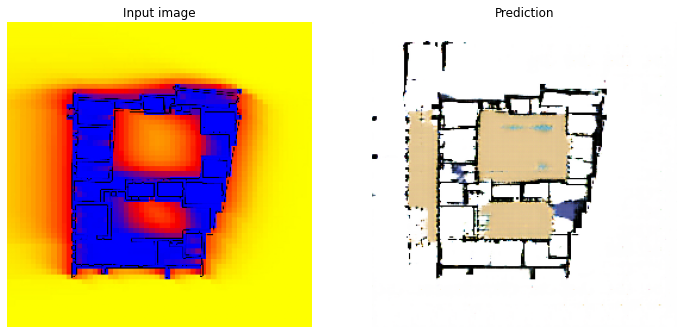

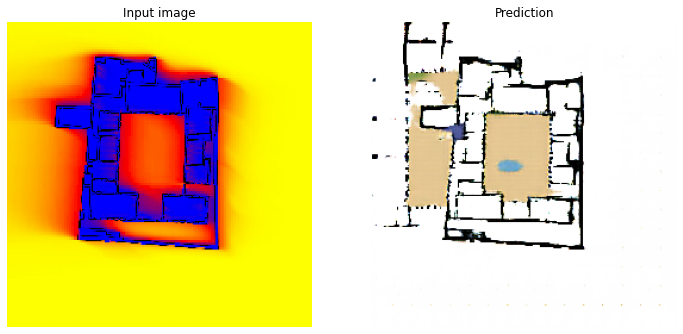

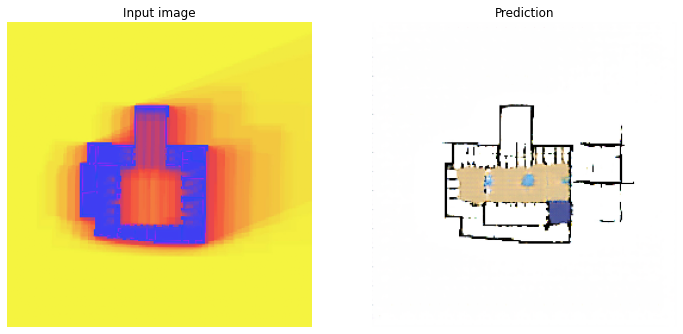

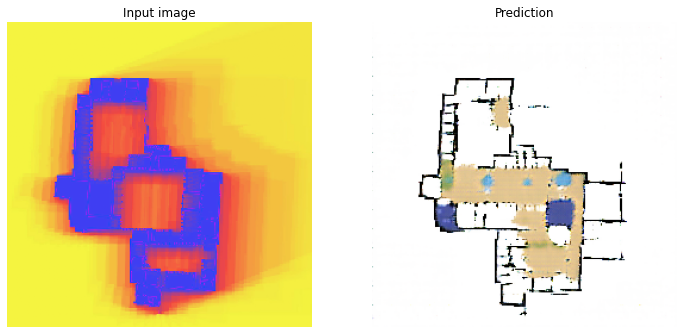

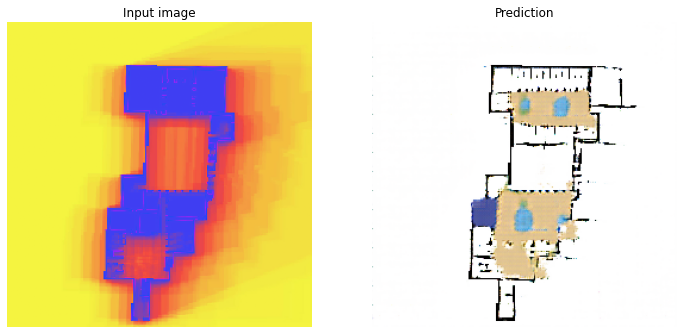

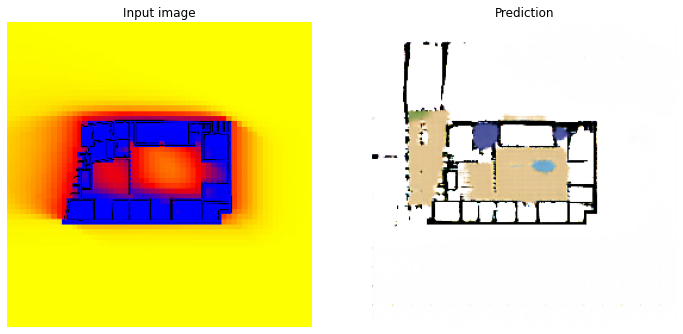

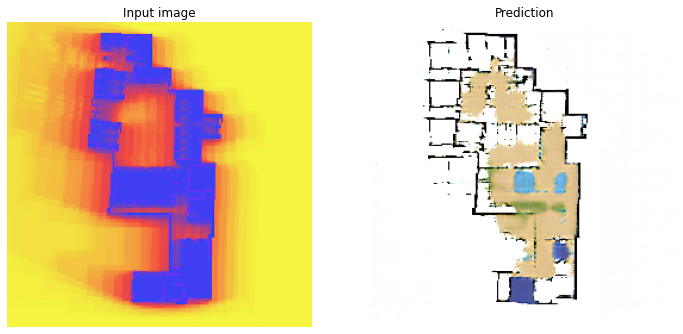

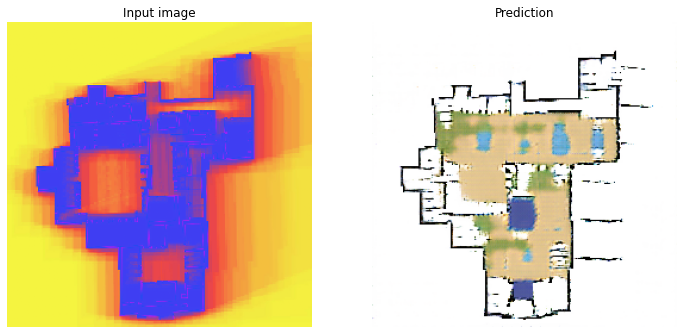

In [ ]:
test_data = get_data(path + "/testA/*" + data_format, path + "/testB/*" + data_format)
sample_test = next(iter(test_data))
for inp, tar in test_data.take(-1):
    generate_images(generator_g, inp)

In [ ]:
"""
# Graphs of training loss (incompleted)
num_epochs = []
for i in range(EPOCHS):
  num_epochs.append(i)
  print(LOSS[i])  
                    
print(LOSS)  
plt.plot(e, LOSS)
"""

'\n# Graphs of training loss (incompleted)\nnum_epochs = []\nfor i in range(EPOCHS):\n  num_epochs.append(i)\n  print(LOSS[i])  \n                    \nprint(LOSS)  \nplt.plot(e, LOSS)\n'